In [1]:
# Import Dependencies
import matplotlib
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
#Here I am declaring a base using the automap_base function
Base = automap_base()

# Now that I have my variable base defined I can use it to reflect the database tables in
Base.prepare(engine, reflect=True)

In [6]:
# Print all of the tables mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [7]:
# Now I want a list of the columns in each table
inspector = inspect(engine)

In [8]:
# First I am going to get a list of columns from measurment
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
# First I am going to get a list of columns from measurment
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement).order_by(measurement.date.desc()).first()
#This is a string I want to convert it to a date
most_rec_date = datetime.strptime(most_recent_date.date, '%Y-%m-%d')
print(most_rec_date)

2017-08-23 00:00:00


In [13]:
# Find one year ago from this date
year_ago_most_rec_date = most_rec_date - relativedelta(years=1)
print(year_ago_most_rec_date)

2016-08-23 00:00:00


In [14]:
# I have to go back an extra day or else the last date in a full year back is not included
year_ago_most_rec_date = year_ago_most_rec_date - relativedelta(days=1)

In [15]:
#Query the last 12 months of the measurement data
last_year_prcp= session.query(measurement.date, measurement.prcp).filter(measurement.date>=year_ago_most_rec_date).\
                filter(measurement.date<most_rec_date).all()

In [16]:
# Save the query results as a Pandas DataFrame
last_year_df = pd.DataFrame(last_year_prcp, columns=['date', 'prcp'])
last_year_df.set_index('date', inplace=True, )
last_year_df.head(5)

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [17]:
# Here I am going to sort by date to make sure the dataframe is in the correct order 
last_year_df = last_year_df.sort_values("date")
last_year_df.head(10)

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70
2016-08-23,0.02
2016-08-24,0.08
2016-08-24,2.15


In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_year_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [19]:
# Design a query to calculate the total number stations in the dataset
distinct_stations = session.query(measurement).group_by(measurement.station).count()
print(distinct_stations)

9


In [20]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# We can see the which station had the most rows by looking at the output above but here I will ust code to automatically find out 
most_active_station = session.query(measurement.station).group_by(measurement.station).\
                        order_by(func.count(measurement.station).desc()).first()
print(most_active_station.station)

USC00519281


In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
max_temp = session.query(measurement.tobs, func.max(measurement.tobs)).filter(measurement.station == most_active_station.station).one()
min_temp = session.query(measurement.tobs, func.min(measurement.tobs)).filter(measurement.station == most_active_station.station).one()
mean_temp = session.query(func.avg(measurement.tobs)).filter(measurement.station == most_active_station.station).one()
print(f"The most common station in the table is {most_active_station.station}")
print(f"The maximum temperature for this station is {max_temp.tobs}")
print(f"The minimum temperature for this station is {min_temp.tobs}")
print(f"The average temperature for this station is {mean_temp}")

The most common station in the table is USC00519281
The maximum temperature for this station is 85.0
The minimum temperature for this station is 54.0
The average temperature for this station is (71.66378066378067,)


In [23]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station
last_year_tobs = session.query(measurement.tobs).filter(measurement.station == most_active_station.station).\
    filter(measurement.date>=year_ago_most_rec_date).filter(measurement.date<most_rec_date).all()

In [24]:
# Clean up query results to get a list of numbers
last_year_temp = []
for i in range(0,len(last_year_tobs)):
    last_year_temp.append(last_year_tobs[i].tobs)
print(last_year_temp)

[77.0, 77.0, 80.0, 80.0, 75.0, 73.0, 78.0, 77.0, 78.0, 80.0, 80.0, 78.0, 78.0, 78.0, 73.0, 74.0, 80.0, 79.0, 77.0, 80.0, 76.0, 79.0, 75.0, 79.0, 78.0, 79.0, 78.0, 78.0, 76.0, 74.0, 77.0, 78.0, 79.0, 79.0, 77.0, 80.0, 78.0, 78.0, 78.0, 77.0, 79.0, 79.0, 79.0, 79.0, 75.0, 76.0, 73.0, 72.0, 71.0, 77.0, 79.0, 78.0, 79.0, 77.0, 79.0, 77.0, 78.0, 78.0, 78.0, 78.0, 77.0, 74.0, 75.0, 76.0, 73.0, 76.0, 74.0, 77.0, 76.0, 76.0, 74.0, 75.0, 75.0, 75.0, 75.0, 71.0, 63.0, 70.0, 68.0, 67.0, 77.0, 74.0, 77.0, 76.0, 76.0, 75.0, 76.0, 75.0, 73.0, 75.0, 73.0, 75.0, 74.0, 75.0, 74.0, 75.0, 73.0, 75.0, 73.0, 73.0, 74.0, 70.0, 72.0, 70.0, 67.0, 67.0, 69.0, 70.0, 68.0, 69.0, 69.0, 66.0, 65.0, 68.0, 62.0, 75.0, 70.0, 69.0, 76.0, 76.0, 74.0, 73.0, 71.0, 74.0, 74.0, 72.0, 71.0, 72.0, 74.0, 69.0, 67.0, 72.0, 70.0, 64.0, 63.0, 63.0, 62.0, 70.0, 70.0, 62.0, 62.0, 63.0, 65.0, 69.0, 77.0, 70.0, 74.0, 69.0, 72.0, 71.0, 69.0, 71.0, 71.0, 72.0, 72.0, 69.0, 70.0, 66.0, 65.0, 69.0, 68.0, 68.0, 68.0, 59.0, 60.0, 70.0, 73.

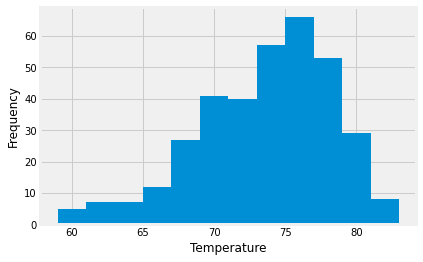

In [26]:
# Plot histogram of 
plt.hist(last_year_temp,bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

# Close session

In [27]:
# Close Session
session.close()